In [1]:
import mdtraj as md
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from tqdm import tqdm
from math import e

def _atom_selection(topology, residue_selection, selection, verbose):
    """
    Function takes a topology file and residue selection and verifies if
    the lattter is possible. It also returns the C-alpha atom selection
    Input:
        topology: 
            mdtraj.Topology or string
            Either mdtraj.Topology object or path to trajectory
            to be loaded
        residue_selection:
            string or list with integers
            String will be interpreted with the Mdtraj atom
            selection language. The list will be treated as
            atom number
        selection (by default True):
            boolean
            if true the function will try to return the residue/
            atom selection
    Output:
        atom_subset
            numpy.array 
            array with all the atom numbers corresponding to selection
        md_topology
            mdtraj.core.topology.Topology object of protein 
    """
    ## First have to load all the inputs if they are defined by a path
    if isinstance(topology, str):
        if os.path.exists(topology):
            try:
                md_topology = md.load_topology(topology)
            except:
                sys.exit('Make sure you have provided a valid path to topology file!')
            else:
                if verbose > 0:
                    print 'The following topology file was succesfully loaded: \n %s \n' %(md_topology)

    elif isinstance(topology, md.core.topology.Topology):
        md_topology = topology
        if verbose > 0:
            print 'The following topology file was succesfully loaded: \n %s \n' %(md_topology)
    else:
        sys.exit('Invalid input! Must be a valid path to topology file or mdtraj.Topology object')
    
    ## if selection is True the function will try to obtain the specified atoms/residues
    ## if residue name is specified it will by default look for C-alpha atoms
    if selection:
        if isinstance(residue_selection, list):
            try:
                atom_subset = md_topology.select(residue_selection)
            except:
                sys.exit('Invalid atom selection in list!')
            else:
                if verbose > 1:
                    print 'Your selection includes the following atom(s): \n %s \n' %(atom_subset)
                    print 'Your selection includes the following residues: \n'
                    for residue in md_topology.subset(atom_subset).residues:
                        print residue
        elif isinstance(residue_selection, str):
            try:
                atom_subset = md_topology.select(residue_selection)
            except:
                sys.exit('Check if your atom selection command is recognized by the Mdtraj atom selection language!')
            else:
                if verbose > 1:
                    print 'Your selection includes the following atom(s): \n %s \n' %(atom_subset)
                    print 'Your selection includes the following residues: \n'
                    for residue in md_topology.subset(atom_subset).residues:
                        print residue
        else:
            sys.exit('Make sure you provided a valid residue selection!')
    else:
        atom_subset=md_topology.select('backbone')
    
    # now that we are sure that both topology and selection are valid we can return atom_subset
    # and use the loaded topology file
    
    return atom_subset, md_topology

def _load_traj_xyz(md_topology, trajectory, atom_subset, verbose, chunk, stride):
    """
    Returns xyz coordinates of all requested trajectories
    """
    
    # first create a list with all the paths that are needed
    try:
        trajectory_path = os.listdir(trajectory)
    except:
        sys.exit('Make sure you have provided a string for a valid path to a trajectory file!')
    else:
        if verbose > 0:
            print 'Loading trajectories from the following files: '
            for trajectory_i in trajectory_path:
                print trajectory_i
                
    # get first frame for superpositioning
    first_frame = md.load(trajectory + trajectory_path[0], frame=0, top=md_topology, atom_indices=atom_subset)
    
    # initiate some variables
    all_coordinates = []
    number_of_frames = 0
    sim_time = []
    
    # now we need to load each trajectory file as a chunk
    try:
        for file_i in trajectory_path:
            
            for chunk_i in md.iterload(trajectory + file_i, chunk, top=md_topology, atom_indices = atom_subset, stride = stride):
                        
                sim_time.append(chunk_i.time)
                
                # superpose each chunk to first frame
                chunk_i.superpose(first_frame, 0)

                if verbose > 1:
                    print 'Successfully loaded trajectory: \n %s' %(chunk_i)

                all_coordinates.append(chunk_i.xyz.reshape(chunk_i.n_frames, chunk_i.n_atoms * 3))
                        
                        
        all_coordinates_np = np.concatenate(all_coordinates)
    except:
        sys.exit('Make sure you provided a valid path to a folder with trajectory files!')
    else:
        print '\nSuccesfully loaded coordinates for %s atoms from %s out of %s frames!' %(all_coordinates_np.shape[1] / 3, all_coordinates_np.shape[0], all_coordinates_np.shape[0] * stride)
    
    
    sim_time = np.concatenate(sim_time)
    
    return all_coordinates_np, sim_time

# code obtained from Carnegie Mellon University, with small modifications
# Copyright (c) 1995-2004 Carnegie Mellon University. All rights reserved.
def multi_kl(p, q, base):
    """Kullback-Leibler divergence from multinomial p to multinomial q,
    expressed in nats."""
    if (len(q.shape) == 2):
        axis = 1
    else:
        axis = 0
    # Clip before taking logarithm to avoid NaNs (but still exclude
    # zero-probability mixtures from the calculation)

    
    return (p * (np.log(p.clip(1e-10,1)) / np.log(base)
            - (np.log(q.clip(1e-10,1)) / np.log(base)))).sum(axis)


# code obtained from Carnegie Mellon University, with small modifications
# Copyright (c) 1995-2004 Carnegie Mellon University. All rights reserved.
def multi_js(p, q, base):
    """Jensen-Shannon divergence (symmetric) between two multinomials,
    expressed in nats."""
    if (len(q.shape) == 2):
        axis = 1
    else:
        axis = 0
    # D_{JS}(P\|Q) = (D_{KL}(P\|Q) + D_{KL}(Q\|P)) / 2

    return 0.5 * ((q * (np.log(q.clip(1e-10,1)) / np.log(base)
                        - np.log(p.clip(1e-10,1)) / np.log(base))).sum(axis)
                      + (p * (np.log(p.clip(1e-10,1)) / np.log(base)
                              - np.log(q.clip(1e-10,1)) / np.log(base))).sum(axis))

def _PCA(traj_xyz, components):
    
    pca_xyz = PCA(n_components=components)
    
    reduced_cartesian = pca_xyz.fit_transform(traj_xyz)
    
    return reduced_cartesian
    
def _divergence(method, pca_run2_reduced_cartesian, stride, divergence_base, eval_1, x):
    
    div_PCA = []
    
    pbar = tqdm(total=pca_run2_reduced_cartesian.shape[0]*stride, unit= 'Frame')
    
    if method == 'Kullback-Leibler':

        for frame in range(1, pca_run2_reduced_cartesian.shape[0] + 1):

            #if verbose and frame * stride % 1000 == 0:

                #print 'Calculating KLD for frame %s/%s (KLD calculation time %.2f seconds)' %(frame * stride, pca_run2_reduced_cartesian.shape[0] * stride, time.time() - KLD_start)

            kde_n = gaussian_kde(pca_run2_reduced_cartesian[:frame + 1,0])

            div_PCA.append(multi_kl(kde_n(x), eval_1, divergence_base))

            pbar.update(stride)
            
    elif method == 'Jensen-Shannon':

        for frame in range(1, pca_run2_reduced_cartesian.shape[0] + 1):

            #if verbose and frame * stride % 1000 == 0:

                #print 'Calculating KLD for frame %s/%s (KLD calculation time %.2f seconds)' %(frame * stride, pca_run2_reduced_cartesian.shape[0] * stride, time.time() - KLD_start)

            kde_n = gaussian_kde(pca_run2_reduced_cartesian[:frame + 1,0])

            div_PCA.append(multi_js(kde_n(x), eval_1, divergence_base))

            pbar.update(stride)
            
    else:
        sys.exit('Choose a valid divergence method: \nJensen-Shannon \nKullback-Leibler')
            
    return div_PCA


def main(topology, trajectory1, trajectory2, residue_selection = None, verbose = 1,  chunk = 100, stride = 1, plot_divergence = True, divergence_base = e, divergence_method = 'Kullback-Leibler'):
    """
    Function to perform PCA on 2 runs and 
    return KLD or JSD of distribution over time
    
    Input:
        topology:
            str
            path to topology file
        trajectory1:
            str
            path to folder with trajectory files for 
            first run
        trajectory2:
            str
            path to folder with trajectory files for 
            second run (order only important if performing
            KLD)
        residue_selection:
            str (optional)
            Default = None (chooses the whole protein backbone)
            residue selection using a
            command recognized by MDtraj residue
            selection language (similar to PyMol)
        verbose:
            int (optional)
            Default = 1
            Change to vary amount of info shown (0,1,2)
        chunk:
            int (optional)
            Default = 100
            number of frames loaded at a time
        stride:
            int (optional)
            Default = 1
            number of frames to skip
            i.e. = 1 loads all the frames
        plot_divergence
            boolean
            Default = True
            plots divergence over frame number
        divergence_base
            int
            Default = e
            base of log in divergence calculation
        divergence_method
            str
            Default = 'Kullback-Leibler'
            method to calculate entropy/ divergence
            can be either 'Kullback-Leibler' or
            'Jensen-Shannon'    
    """
    
    if residue_selection == None:
        # will pick all the backbone from protein
        selection = False
    else:
        selection = True
    
    if verbose > 0:
        # timer for the whole function and run 1
        start_1 = time.time()
        
    # now load topology and verify selection by calling _atom_selection()
    atom_subset, md_topology = _atom_selection(topology, residue_selection, selection, verbose)
    
    # RUN 1
    
    # now we need to load the trajectory coordinates for each file in folder
    all_coordinates_run1, sim_time_run1 = _load_traj_xyz(md_topology, trajectory1, atom_subset, verbose, chunk, stride)
    
    if verbose > 0:
        print 'Loading time: %.2f seconds \n' %(time.time() - start_1)
        
        
    if verbose > 0:
        # timer for the PCA
        start_PCA_run1 = time.time()
        
    # calculate PCA and convert data to A
        
    pca_run1_reduced_cartesian = _PCA(all_coordinates_run1 * 10, components=1)
    
    # gaussian kde of PCA 
    
    kde_run1 = gaussian_kde(pca_run1_reduced_cartesian[:,0])
    
    if verbose > 0:
        print 'Run 1 PCA and KDE calculation time: %.2f seconds \n' %(time.time() - start_PCA_run1)

    # RUN 2
    
    if verbose > 0:
        # timer for run 2
        start_2 = time.time()
    
    # now we need to load the trajectory coordinates for each file in folder
    all_coordinates_run2, sim_time_run2 = _load_traj_xyz(md_topology, trajectory2, atom_subset, verbose, chunk, stride)
    
    if verbose > 0:
        print 'Loading time: %.2f seconds \n' %(time.time() - start_2)
        
        
    if verbose > 0:
        # timer for the PCA
        start_PCA_run2 = time.time()

    # calculate PCA and convert data to A
    
    pca_run2_reduced_cartesian = _PCA(all_coordinates_run2 * 10, components=1)
    
    # gaussian kde of PCA for plot
    
    kde_run2 = gaussian_kde(pca_run2_reduced_cartesian[:,0])
    
    if verbose > 0:
        print 'Run 2 PCA and KDE calculation time: %.2f seconds \n' %(time.time() - start_PCA_run2)
        
    x = range(int(min(np.append(pca_run1_reduced_cartesian, pca_run2_reduced_cartesian)) * 1.5), 
              int(max(np.append(pca_run1_reduced_cartesian, pca_run2_reduced_cartesian)) * 1.5))
    
    if verbose > 0:
        
        div_start = time.time()
        
        print 'Starting %s divergence calculation' % divergence_method
        
    eval_1 = kde_run1(x)
    
    div_PCA = _divergence(divergence_method, pca_run2_reduced_cartesian, stride, divergence_base, eval_1, x)
    

    if verbose > 0:
        print '\n%s divergence calculation time: %.2f seconds \n' %(divergence_method, time.time() - div_start)
    
            

    
    if plot_divergence:
        
        plt.figure(figsize=(12,12))
        plt.plot(range(1, len(div_PCA * stride) + 1, stride), div_PCA)
        plt.xlabel('Frame number', size = 16)
        plt.ylabel('%s Divergence' % divergence_method, size = 16)
        plt.title('%s Divergence of PCA over time' % divergence_method, size = 22)
        plt.show() 
    
    plt.figure(figsize=(12,12))
    plt.title('PC1 distribution in run 1 and run 2', size = 24)
    plt.xlabel('PC 1', size = 16)
    plt.ylabel('Density', size = 16)
    plt.plot(x,kde_run1(x), label = 'run 1')
    plt.plot(x, kde_run2(x), label = 'run 2')
    plt.legend(loc = 'best', prop = {'size': 16})
    plt.show()
    
    if verbose > 0:
        
        total_trajectory_time_1 = (sim_time_run1[-1] - sim_time_run1[0])
        total_trajectory_time_2 = (sim_time_run2[-1] - sim_time_run2[0])
        print 'Total execution time: %.2f seconds \n' %(time.time() - start_1)
        print 'Run 1 simulation time: %s ns \n' %(total_trajectory_time_1 / 1000)
        print 'Run 2 simulation time: %s ns \n' %(total_trajectory_time_2 / 1000)
        
    # return  pca_run1_reduced_cartesian, pca_run2_reduced_cartesian, x
        
# Author: Gil Ferreira Hoben

## MD1

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD1_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD1_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD1_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD1_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD1_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD1_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD1_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD1_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD1_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD1_450-500_run1_nowater.nc
05_Prod_troponin_egcg_MD1_500-550_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 27500 out of 27500 frames!
Loading time: 80.37 seconds 

Run 1 PCA and KDE calculation time: 222.67 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD1_000-050_run2_nowater.nc
05_Prod_troponin

100%|██████████| 21940/21940 [2:50:23<00:00,  1.74Frame/s]


Kullback-Leibler divergence calculation time: 10224.88 seconds 



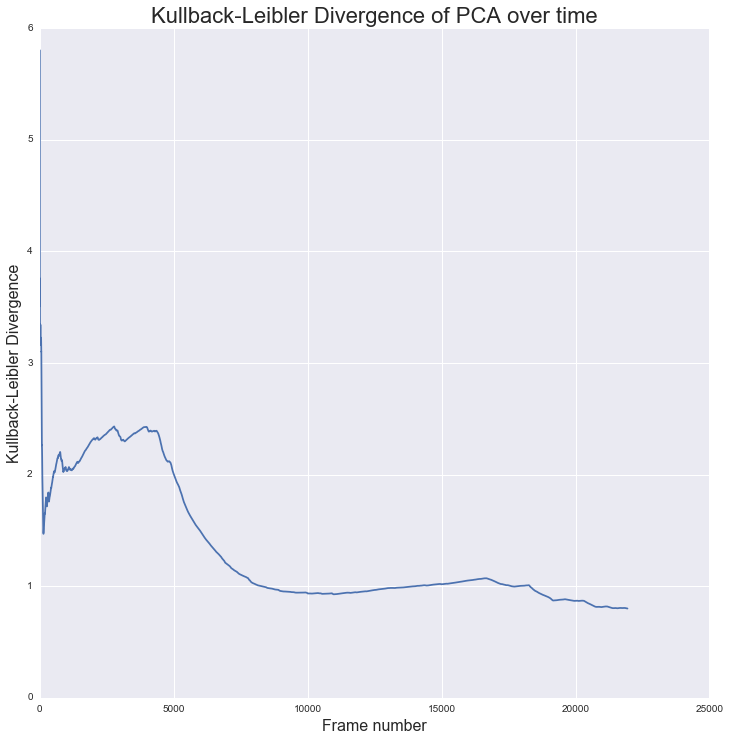

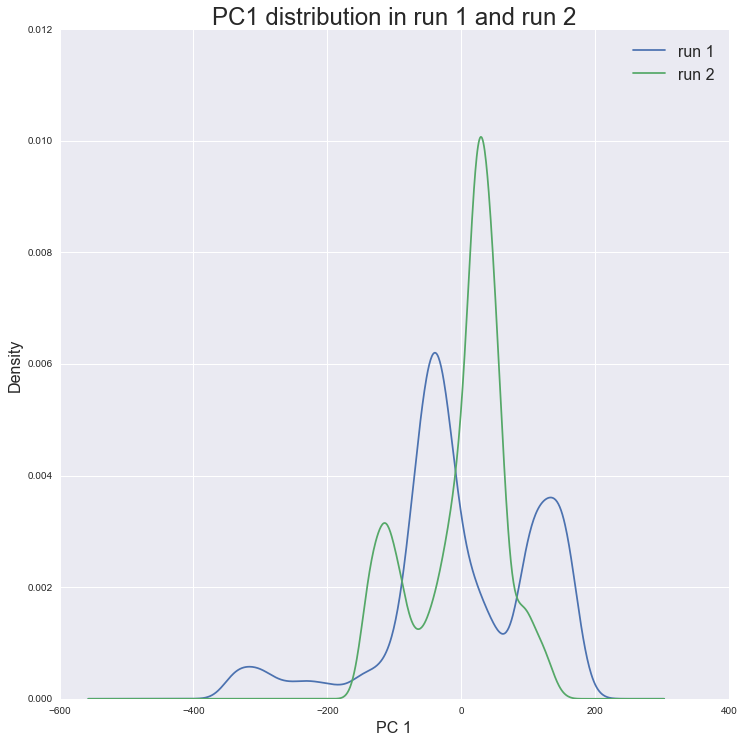

Total execution time: 10889.56 seconds 

Run 1 simulation time: 549.98 ns 

Run 2 simulation time: 436.14 ns 



In [2]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD1/run1/troponin_egcg_MD1_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD1/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD1/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD1_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD1_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD1_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD1_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD1_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD1_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD1_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD1_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD1_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD1_450-500_run1_nowater.nc
05_Prod_troponin_egcg_MD1_500-550_run1_nowater.nc

Succesfully loaded coordinates for 1676 atoms from 27500 out of 27500 frames!
Loading time: 33.22 seconds 

Run 1 PCA and KDE calculation time: 57.24 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD1_000-050_run2_nowater.nc
05_Prod_troponin_

100%|██████████| 21940/21940 [1:28:46<00:00,  2.64Frame/s]


Jensen-Shannon divergence calculation time: 5326.61 seconds 



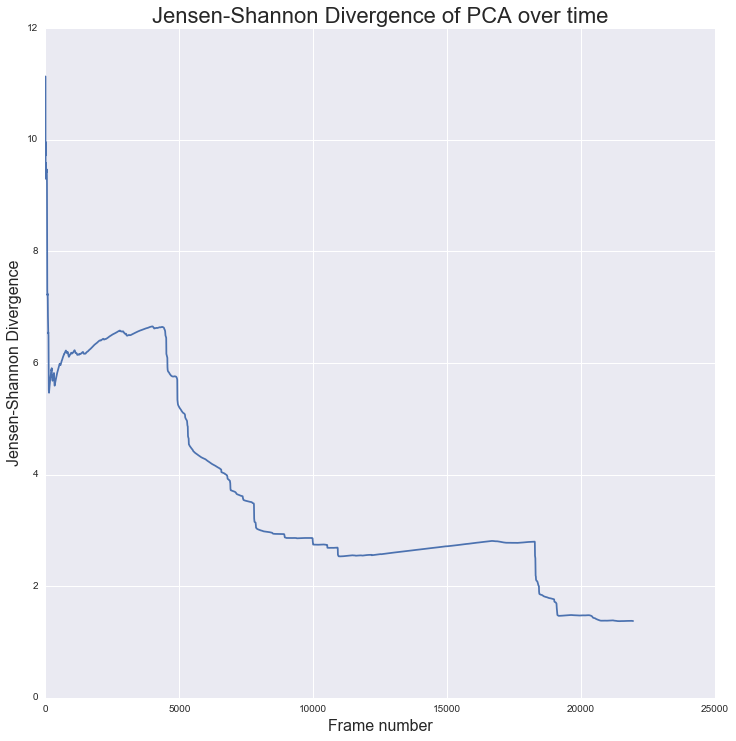

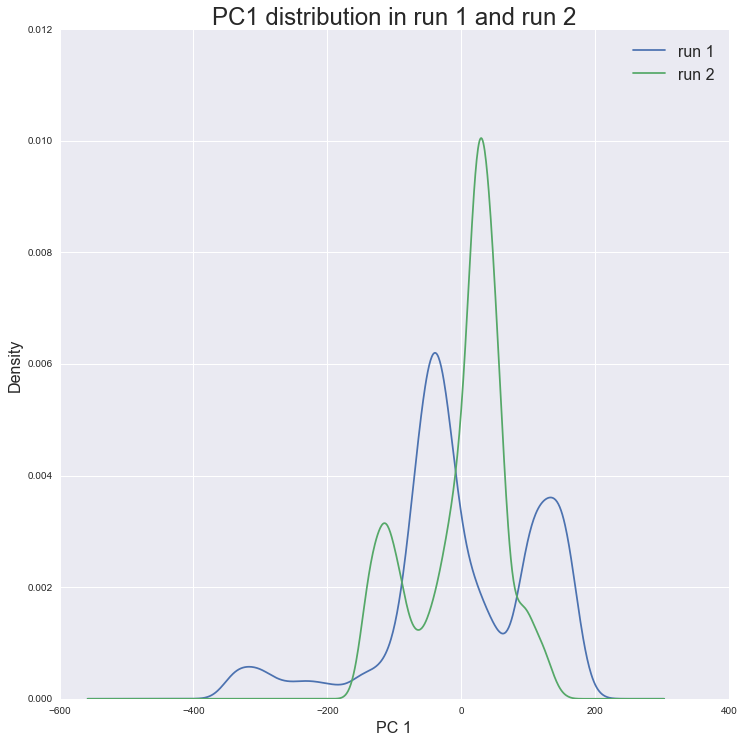

Total execution time: 5488.60 seconds 

Run 1 simulation time: 549.98 ns 

Run 2 simulation time: 436.14 ns 



In [11]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD1/run1/troponin_egcg_MD1_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD1/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD1/run2/Trajectories/'
residue_selection = 'backbone'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e, divergence_method='Jensen-Shannon')

## MD2

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD2_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD2_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD2_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD2_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD2_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD2_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD2_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD2_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD2_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD2_450-500_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 24988 out of 24988 frames!
Loading time: 97.51 seconds 

Run 1 PCA and KDE calculation time: 100.63 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD2_000-050_run2_nowater.nc
05_Prod_troponin_egcg_MD2_050-100_run2_nowater.nc
05_Prod_troponin

100%|██████████| 15807/15807 [1:09:22<00:00,  2.31Frame/s]


Kullback-Leibler divergence calculation time: 4163.53 seconds 



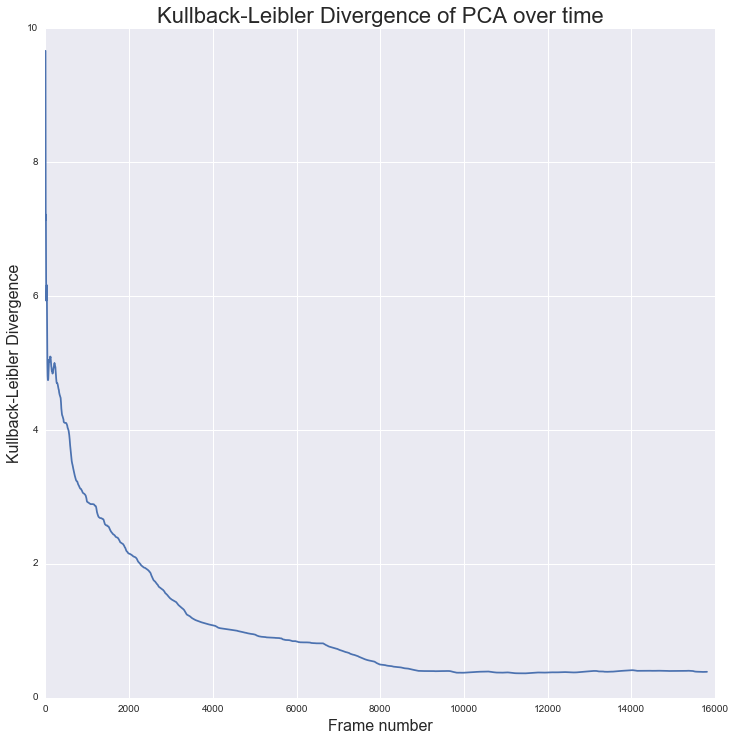

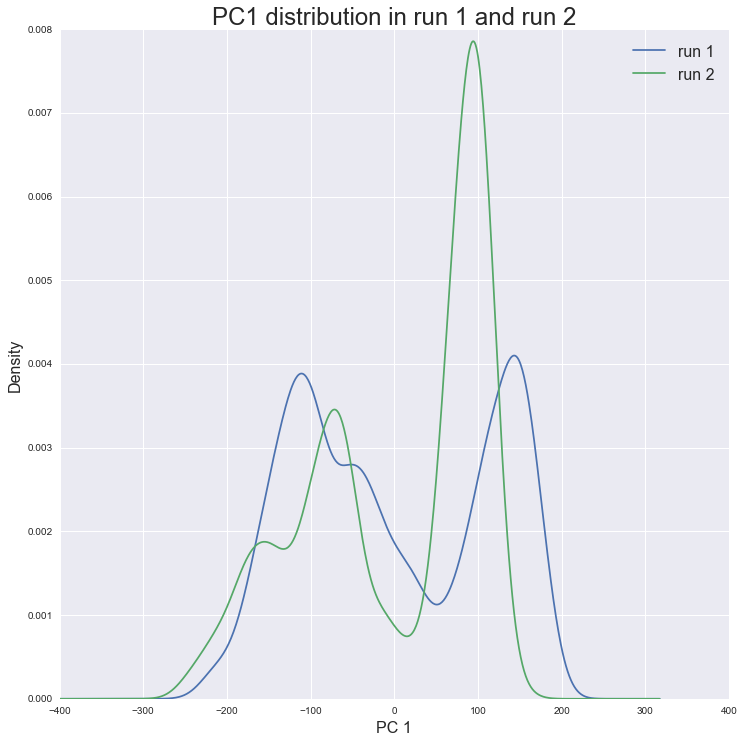

Total execution time: 4475.79 seconds 

Run 1 simulation time: 497.98 ns 

Run 2 simulation time: 310.52 ns 



In [4]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD2/run1/troponin_egcg_MD2_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD2/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD2/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD2_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD2_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD2_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD2_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD2_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD2_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD2_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD2_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD2_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD2_450-500_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 24988 out of 24988 frames!
Loading time: 56.28 seconds 

Run 1 PCA and KDE calculation time: 96.06 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD2_000-050_run2_nowater.nc
05_Prod_troponin_egcg_MD2_050-100_run2_nowater.nc
05_Prod_troponin_

100%|██████████| 15807/15807 [1:11:08<00:00,  2.56Frame/s]


Jensen-Shannon divergence calculation time: 4269.08 seconds 



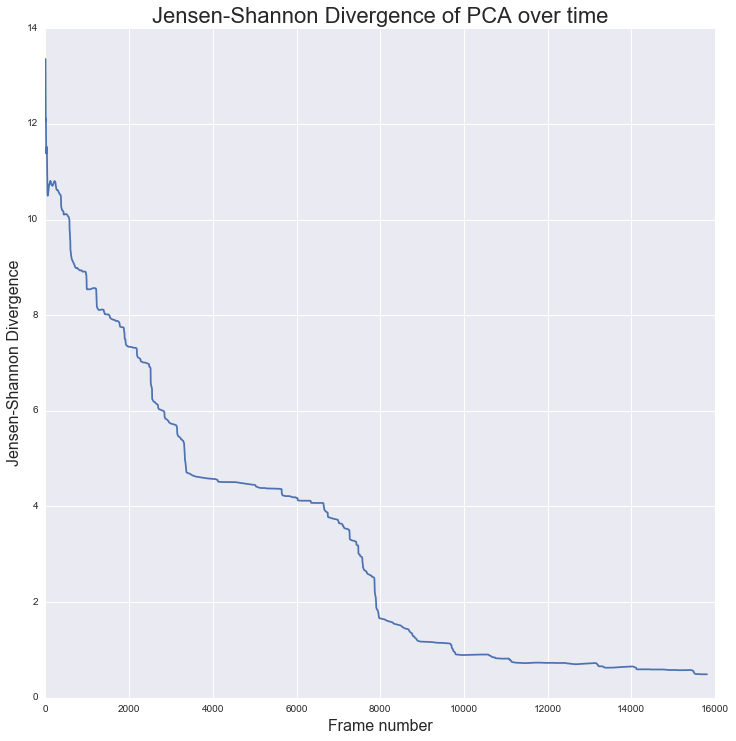

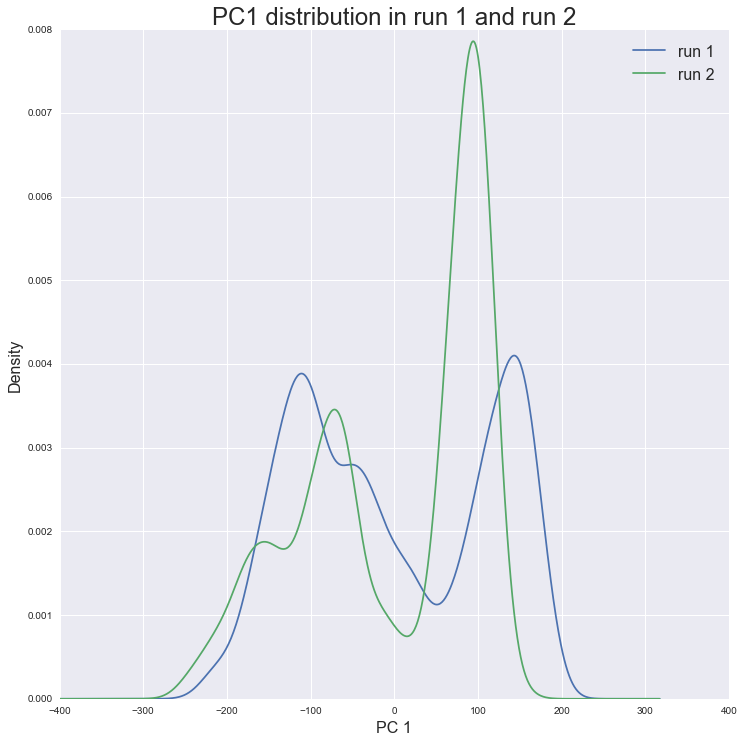

Total execution time: 4536.28 seconds 

Run 1 simulation time: 497.98 ns 

Run 2 simulation time: 310.52 ns 



In [5]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD2/run1/troponin_egcg_MD2_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD2/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD2/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e, divergence_method='Jensen-Shannon')

## MD3

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD3_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD3_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD3_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD3_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD3_450-500_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 24982 out of 24982 frames!
Loading time: 68.88 seconds 

Run 1 PCA and KDE calculation time: 99.07 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run2_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run2_nowater.nc
05_Prod_troponin_

100%|██████████| 15936/15936 [1:24:04<00:00,  2.29Frame/s]


Kullback-Leibler divergence calculation time: 5045.13 seconds 



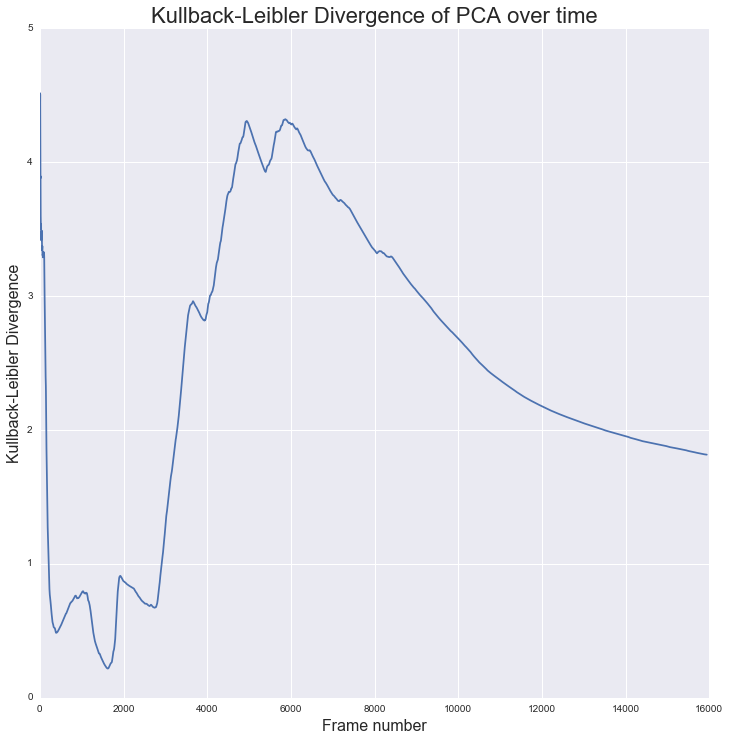

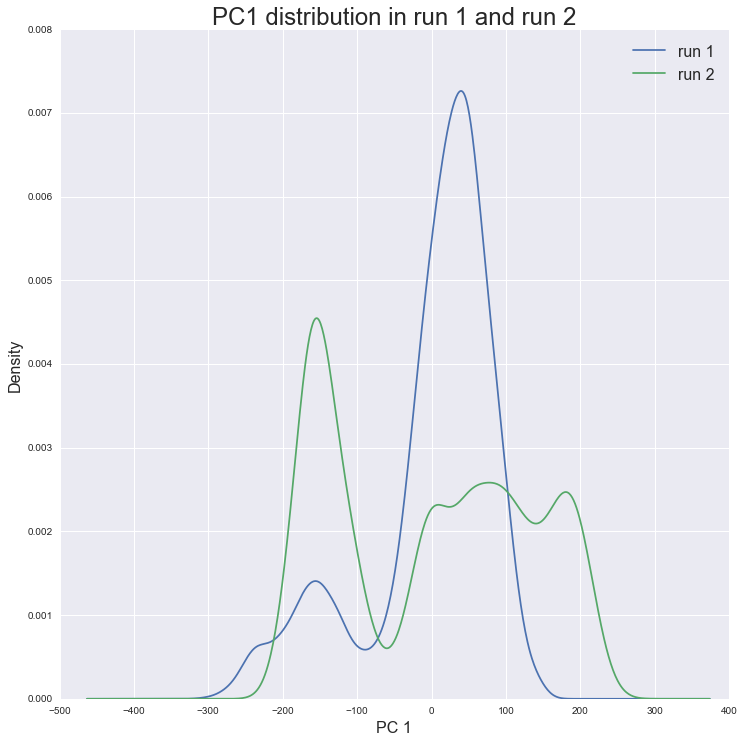

Total execution time: 5331.13 seconds 

Run 1 simulation time: 497.98 ns 

Run 2 simulation time: 312.76 ns 



In [6]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD3/run1/troponin_egcg_MD3_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD3/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD3/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD3_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD3_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD3_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD3_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD3_450-500_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 24982 out of 24982 frames!
Loading time: 39.55 seconds 

Run 1 PCA and KDE calculation time: 74.50 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run2_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run2_nowater.nc
05_Prod_troponin_

100%|██████████| 15936/15936 [1:13:30<00:00,  2.72Frame/s]


Jensen-Shannon divergence calculation time: 4410.99 seconds 



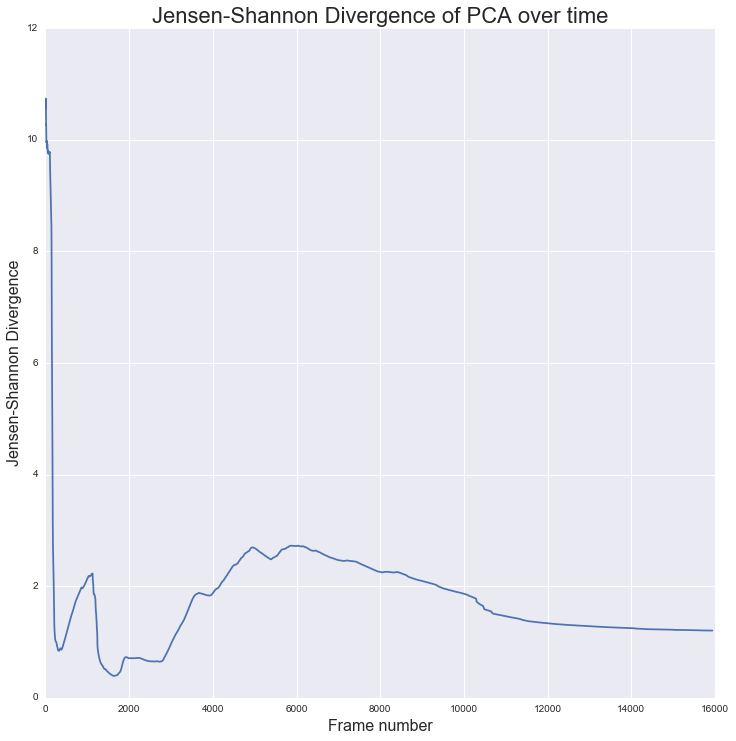

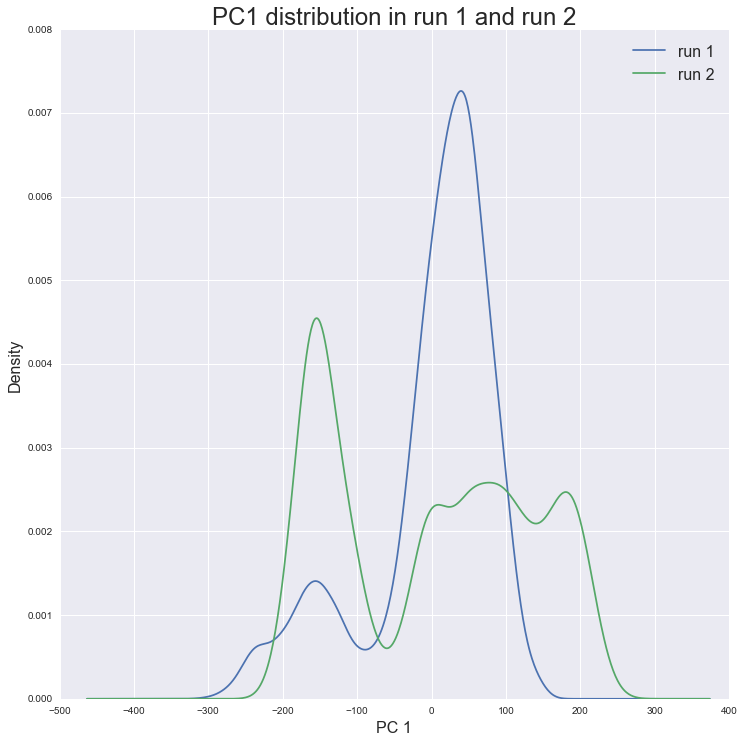

Total execution time: 4607.53 seconds 

Run 1 simulation time: 497.98 ns 

Run 2 simulation time: 312.76 ns 



In [8]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD3/run1/troponin_egcg_MD3_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD3/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD3/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e, divergence_method='Jensen-Shannon')

## MD5

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD5_450-500_run1_nowater.nc
05_Prod_troponin_egcg_MD5_500-550_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 27500 out of 27500 frames!
Loading time: 40.62 seconds 

Run 1 PCA and KDE calculation time: 72.17 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run2_nowater.nc
05_Prod_troponin_

100%|██████████| 17135/17135 [1:27:14<00:00,  2.10Frame/s]


Kullback-Leibler divergence calculation time: 5235.60 seconds 



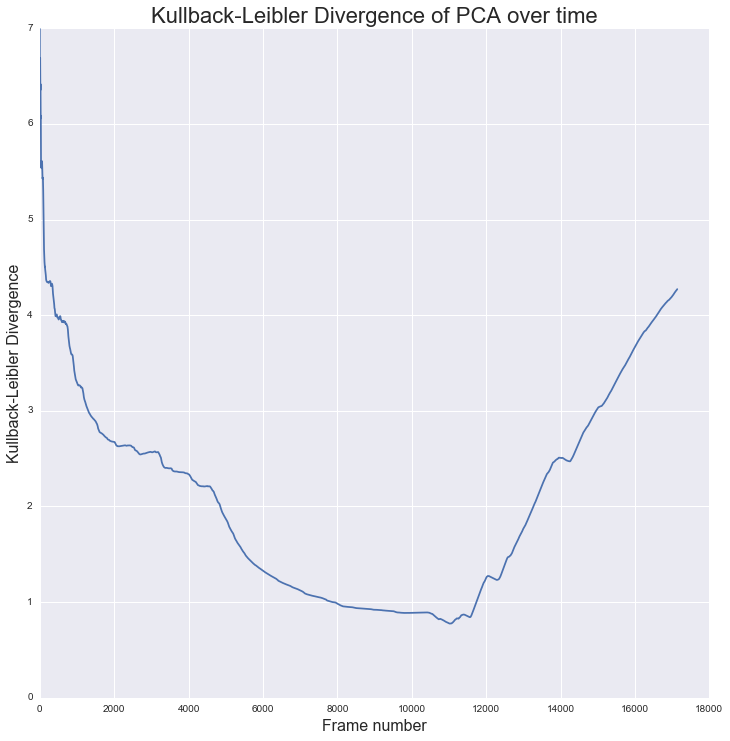

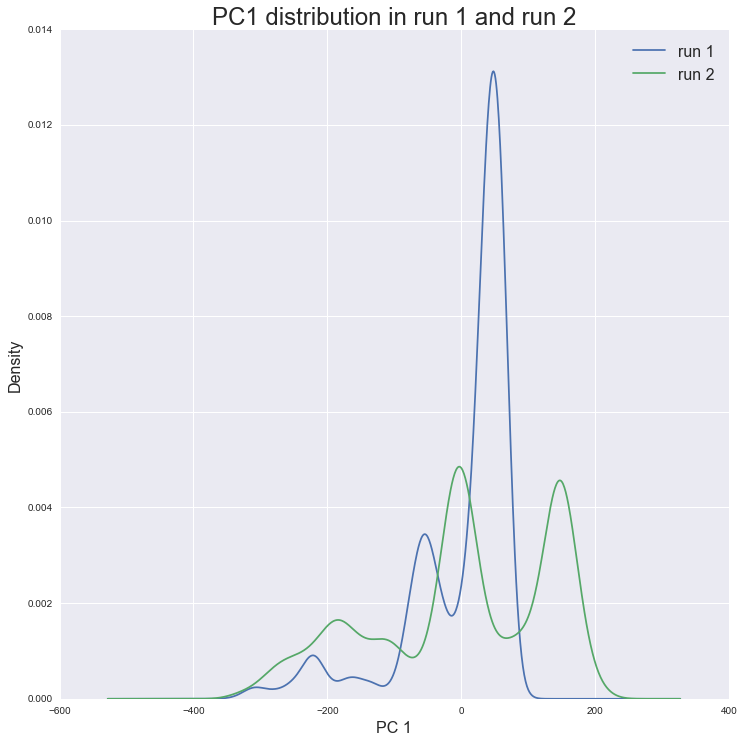

Total execution time: 5428.88 seconds 

Run 1 simulation time: 549.98 ns 

Run 2 simulation time: 337.0 ns 



In [9]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD5/run1/troponin_egcg_MD5_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD5/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD5/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run1_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run1_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run1_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run1_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run1_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run1_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run1_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run1_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run1_nowater.nc
05_Prod_troponin_egcg_MD5_450-500_run1_nowater.nc
05_Prod_troponin_egcg_MD5_500-550_run1_nowater.nc

Succesfully loaded coordinates for 1672 atoms from 27500 out of 27500 frames!
Loading time: 40.30 seconds 

Run 1 PCA and KDE calculation time: 75.30 seconds 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run2_nowater.nc
05_Prod_troponin_

100%|██████████| 17135/17135 [1:36:23<00:00,  1.73Frame/s]


Jensen-Shannon divergence calculation time: 5784.68 seconds 



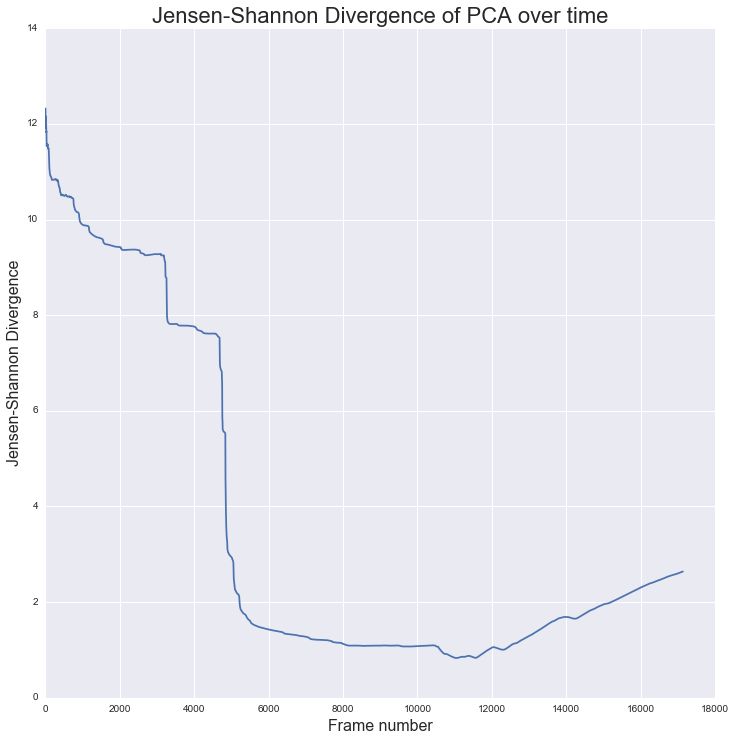

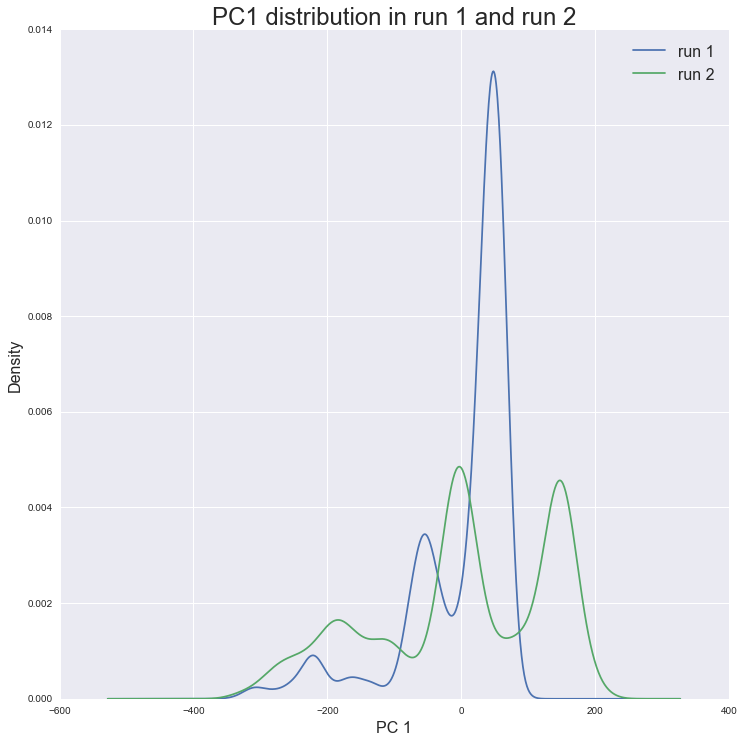

Total execution time: 5993.14 seconds 

Run 1 simulation time: 549.98 ns 

Run 2 simulation time: 337.0 ns 



In [10]:
topology = '/Users/gil_f.hoben/Troponin_md_processed/MD5/run1/troponin_egcg_MD5_nowater.prmtop'
trajectory1 = '/Users/gil_f.hoben/Troponin_md_processed/MD5/run1/Trajectories/'
trajectory2 ='/Users/gil_f.hoben/Troponin_md_processed/MD5/run2/Trajectories/'
residue_selection = 'backbone and resid 1 to 419'
main(topology, trajectory1, trajectory2, residue_selection, verbose = 1, chunk = 100, stride = 1, plot_divergence = True, divergence_base = e, divergence_method='Jensen-Shannon')